In [1]:
%matplotlib inline

from cosima_cookbook import build_index, get_nc_variable
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import joblib
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import IPython.display

netcdf_index loaded.


/home/156/al1353/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
memory = joblib.Memory(cachedir='.')

In [3]:
expts = ['gfdl_nyf_1080_cp','gfdl_nyf_1080_SH','gfdl_nyf_1080_PI','gfdl_nyf_1080_UP']

# Transport

### The transport distribution around the target area ( Indian Ocean, Agulhas Current) for the reference experiment.

In [4]:
@memory.cache
def calc_transportm(expt):
    "Calculate the vertically integrate transport at time 0"
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', 
                             time_units='days since 1900-01-01')

    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .isel(time=0)\
                     .sum('st_ocean')

    streamfunction = tx_trans_inz.cumsum('yt_ocean')

    streamfunction0 = streamfunction.sel(xu_ocean=20, yt_ocean=-10, method='nearest')

    transport = - (streamfunction - streamfunction0)
    
    transport = transport.compute()
    
    return transport

CPU times: user 302 ms, sys: 81 ms, total: 383 ms
Wall time: 18.5 s


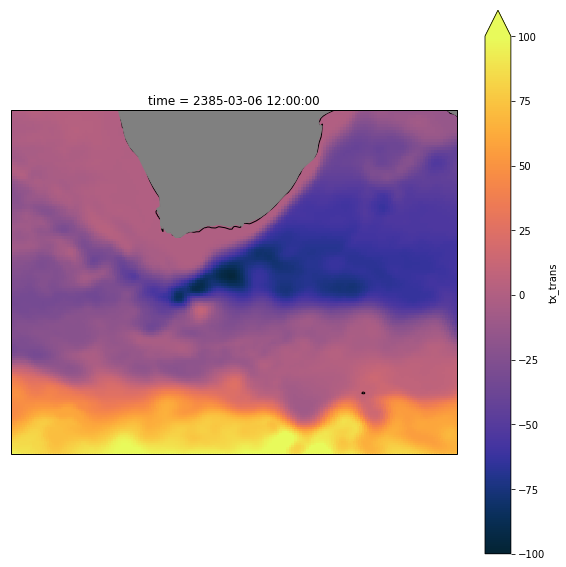

In [5]:
%%time
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=25))
ax.set_extent([5, 45, -50, -25])
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND, color='gray')
transportm = calc_transportm(expts[0])
transportm.plot(cmap=cm.cm.thermal,  transform=ccrs.PlateCarree(), vmin=-100, vmax=100)

### The transport distribution along the x=20 degree transect

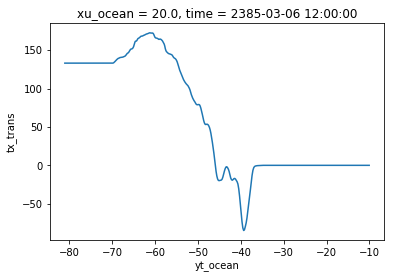

In [6]:
transportm.sel(xu_ocean=20, method='nearest').plot()

# Wind stress for 5 days experiment

In [6]:
@memory.cache
def wind(expt):
    tau_x=get_nc_variable(expt,'ocean__\d+_\d+.nc','tau_x',n=10, time_units='days since 1900-01-01')
    wind_stress=tau_x.mean(dim='time').sel(yu_ocean=slice(-60,-30)).isel(xu_ocean=slice(1000,1400))\
                                                                                  .mean(dim='xu_ocean')
    return wind_stress

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


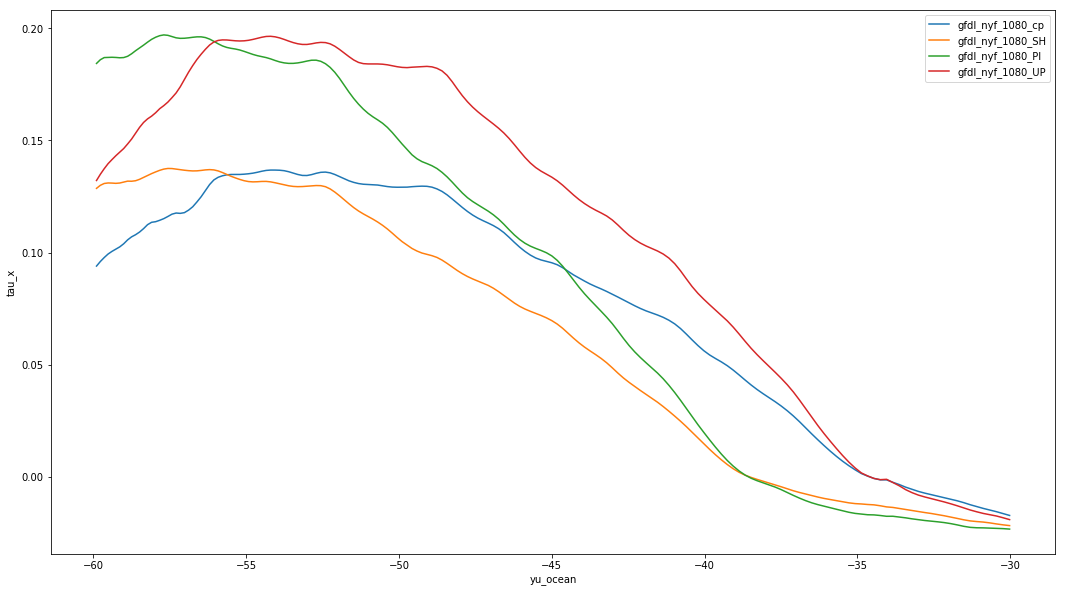

In [7]:
plt.figure(figsize=(18,10))
for expt in expts:
    windstress=wind(expt)
    windstress.plot(label=expt)
plt.legend(loc=0)

# Defining the transport function

In [8]:
@memory.cache
def calc_transport(expt):
    "Calculate the vertically integrate transport at time 0"
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')

    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .sum('st_ocean')  

    streamfunction = tx_trans_inz.cumsum('yt_ocean') # integrate in y direction

    streamfunction0 = streamfunction.sel(xu_ocean=20, yt_ocean=-10, method='nearest') # select somewhere
    # on the continent to be reference point 

    transport = - (streamfunction - streamfunction0) # To make the transport on the continent to be 0
    
    transport = transport.compute()
    
    return transport

# 1.1 Antarctica Circumpolar Current

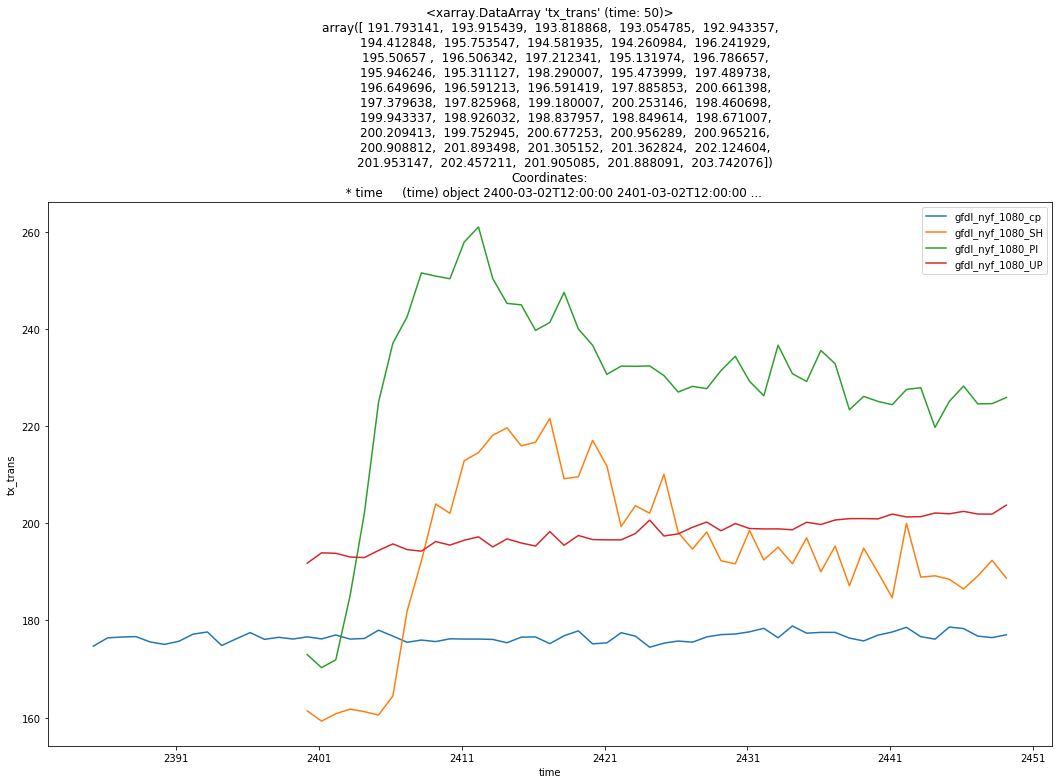

In [9]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport = calc_transport(expt) 
    ACC = transport.sel(xu_ocean=slice(20, 30)).max(dim='yt_ocean').max(dim='xu_ocean')
    ACC.plot(label=expt)
plt.title(ACC)
plt.legend()

As can be seen from the figure, after shifting the windstress to the west, the transport of ACC increse a lot at first and then decrease to the level a little bit higher than the reference. And after strength the windstress, the ACC has a significant increase for the whole period. At last, after strengthing and shifting, the transport experiences a big up and small down and ends with the biggest value of the four.

# 1.2 ACC above the salinity level=35

In [10]:
@memory.cache
def maskacc(expt, saltlevel):
    
    salt=get_nc_variable(expt,'ocean.nc','salt', time_units='days since 1900-01-01')
    transport_salt = salt\
                .sel(yt_ocean=slice(None, -10))\
                .sel(xt_ocean=slice(0,60))\
                .compute()
    acc_mask = (transport_salt >= saltlevel)
    
    return acc_mask

In [11]:
@memory.cache
def calc_transport_mask(expt):
    "Calculate the vertically integrate transport at time 0"
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')

    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .sum('st_ocean')  
    acc_mask = maskacc(expt, 35)                    #add mask
    tx_trans_inz_mask = tx_trans_inz*acc_mask    #mask firstly

    streamfunction_mask = tx_trans_inz_mask.cumsum('yt_ocean') #integrate secondly
    streamfunction0_mask = streamfunction_mask.sel(xu_ocean=20, yt_ocean=-10, method='nearest') #reference ponit

    transport = - (streamfunction_mask - streamfunction0_mask) #reference 3rdly
    transport_mask = transport.compute()
    
    return transport_mask

In [12]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport_mask = calc_transport_mask(expt)
    ACC = transport_mask.sel(xu_ocean=slice(20, 30)).max(dim='yt_ocean').max(dim='xu_ocean')

plt.title('Acc above saliniy level = 35')
plt.legend()

________________________________________________________________________________
[Memory] Calling __main__--home-156-al1353-my_honours_project-__ipython-input__.calc_transport_mask...
calc_transport_mask('gfdl_nyf_1080_cp')


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=65), HTML(value='')))

/home/156/al1353/cosima-cookbook/cosima_cookbook/netcdf_index.py:368: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  decoded_time = xr.conventions.decode_cf_datetime(dataarray.time, time_units)


MemoryError: 

# 2.1 Subgyre_strength

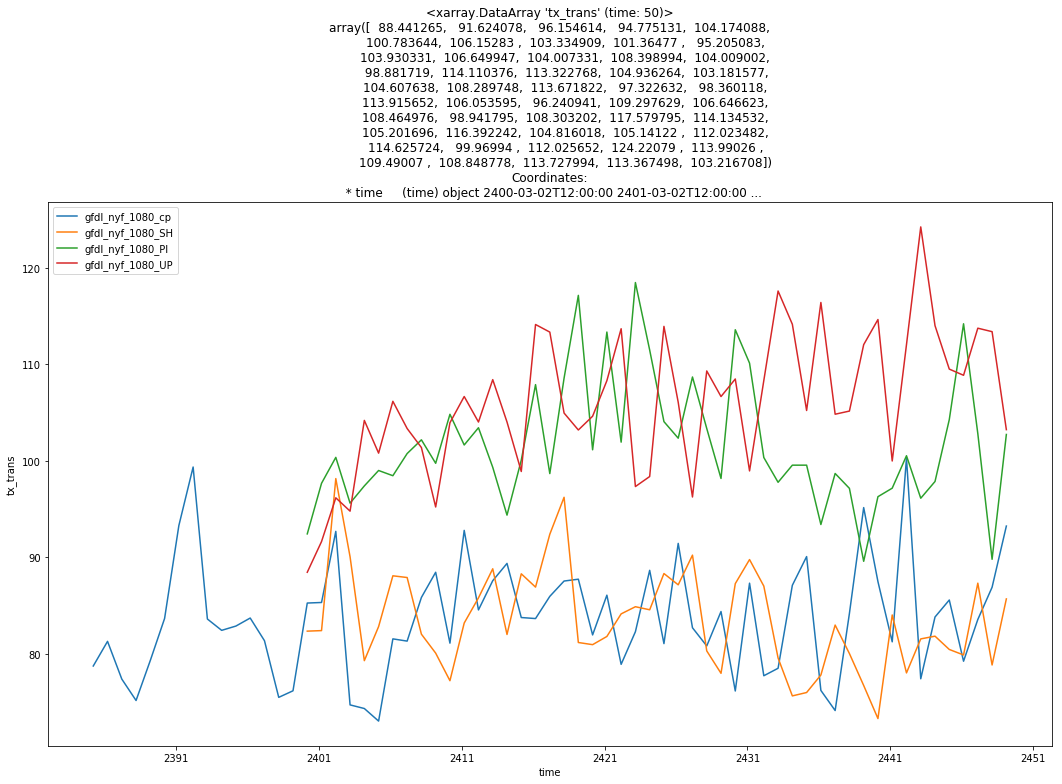

In [14]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport = calc_transport(expt) 
    subgyre_strength = -transport.sel(xu_ocean=slice(30, 60)).min(dim='yt_ocean').min(dim='xu_ocean')
    subgyre_strength.plot(label=expt)
plt.title(subgyre_strength)
plt.legend()

# 3.1 Agulhas Current

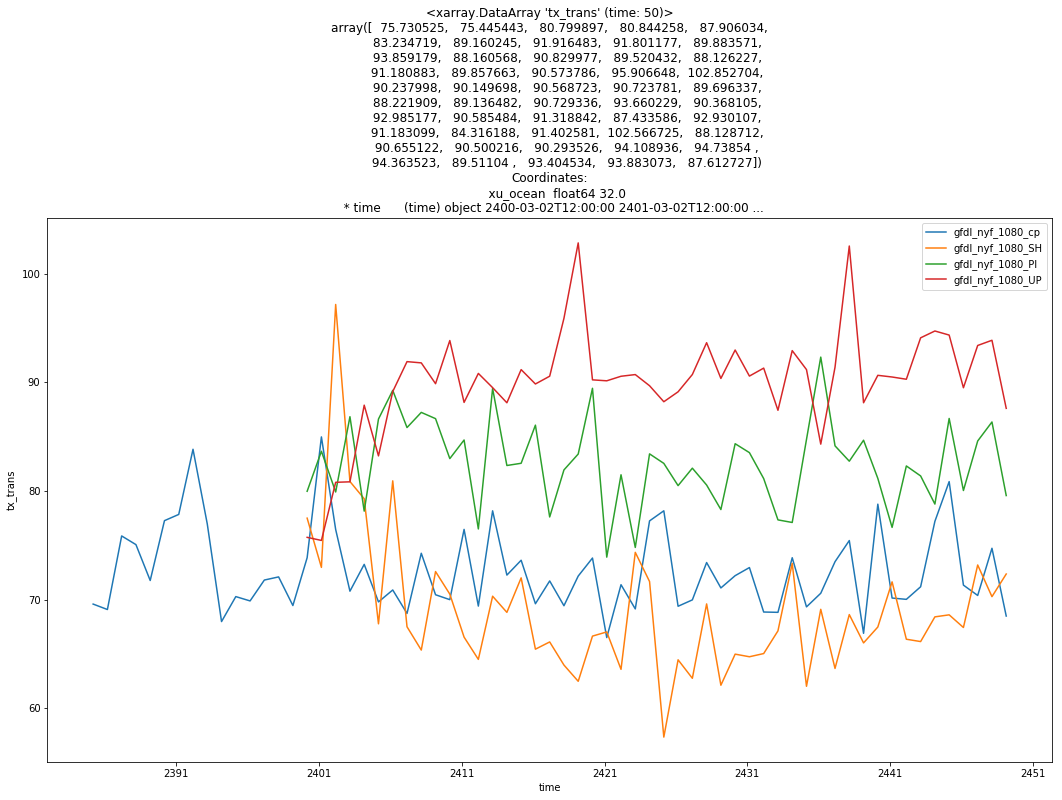

In [15]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport = calc_transport(expt) 
    AC = -transport.sel(xu_ocean=32).min(dim='yt_ocean')
    AC.plot(label=expt)
plt.title(AC)
plt.legend()

 As can be seen, the ressult after shifting of the wind stress for the AC can be say stable or a little bit decrease. However, a direct strength of the wind stress result in a direct increase of the transport. It is interesting that, by observation, the result for the shifting and strengthing of the wind stress has a less value than the  direct strength.

# 4.1 Calculating Agulhas Leakage (AL) by using density layer

In [16]:
@memory.cache
def mask(expt):
    
    rho=get_nc_variable(expt,'ocean.nc','pot_rho_0', time_units='days since 1900-01-01')
    al_rho = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100))\
                .compute()
    al_mask = (al_rho <= 1026.5)
    
    return al_mask

In [17]:
@memory.cache
def calc_altransport(expt):
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')
    al_tx_trans = tx_trans\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xu_ocean=20)\
                .isel(time=slice(None,100))\
                .compute()
    
    return al_tx_trans

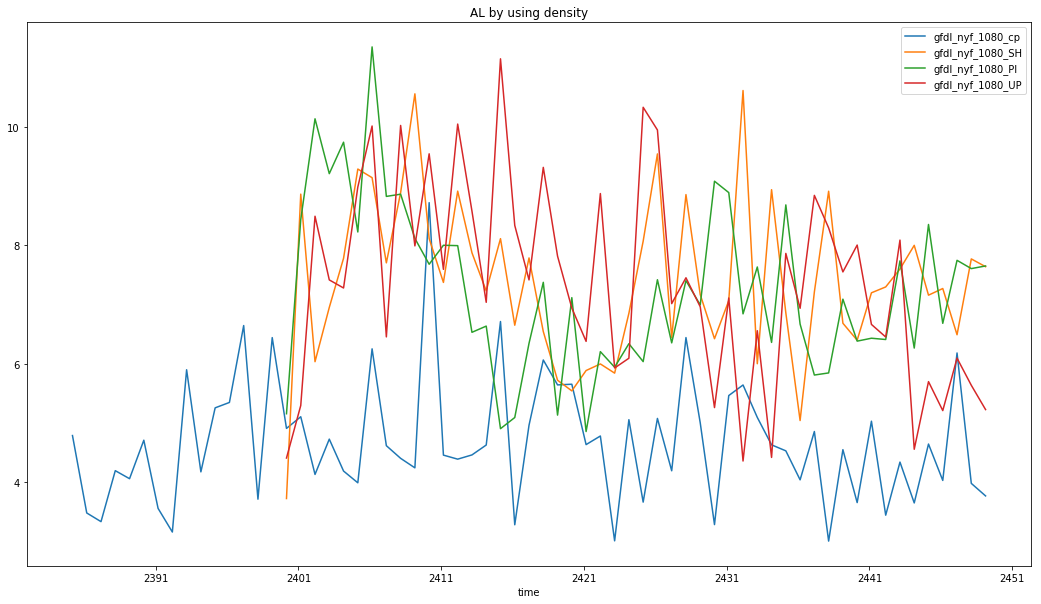

In [18]:
plt.figure(figsize=(18,10))
for expt in expts:
    al_mask = mask(expt)
    al_tx_trans = calc_altransport(expt)
    al_trans = -(al_tx_trans * al_mask).sum('yt_ocean').sum('st_ocean')
    al_trans.plot.line(label=expt)
plt.title('AL by using density')
plt.legend()

# 4.1.1 The 2D transport distribution at x=20, above the density layer = 1026.5 and from y=-42 to y=-37 for 4 experiments.

In [19]:
@memory.cache
def calc_altransport_2d(expt):
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')
    al_tx_trans_2d = tx_trans\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xu_ocean=20)\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return al_tx_trans_2d

In [20]:
@memory.cache
def mask_2d(expt):
    
    rho=get_nc_variable(expt,'ocean.nc','pot_rho_0', time_units='days since 1900-01-01')
    al_rho_2d = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    al_mask_2d = (al_rho_2d <= 1026.5)
    
    return al_mask_2d

In [21]:
@memory.cache
def tdrho(expt):
    
    rho=get_nc_variable(expt,'ocean.nc','pot_rho_0', time_units='days since 1900-01-01')
    al_rho_2d = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return al_rho_2d

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


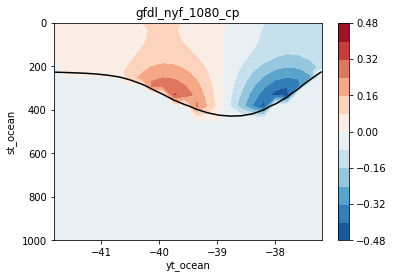

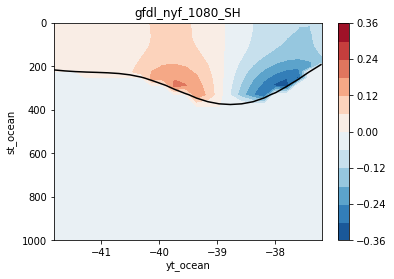

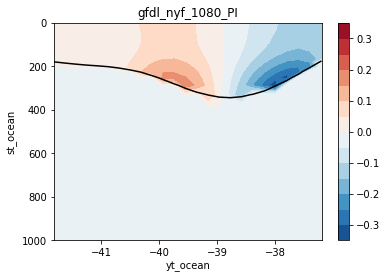

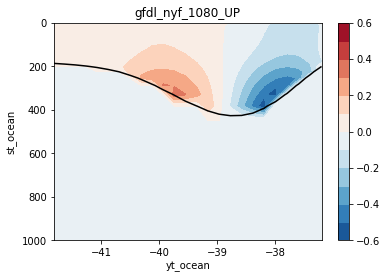

In [22]:
for expt in expts:
    
    al_mask_2d = mask_2d(expt)
    al_tx_trans_2d = calc_altransport_2d(expt)
    al_rho_2d = tdrho(expt)
    plt.figure()
    al_rho_2d.plot.contour(levels=[1026.5], colors='k')
    (al_tx_trans_2d * al_mask_2d).plot.contourf(levels=15)   
    plt.ylim(1000, 0)
    plt.title(expt)

As we can see the transport of the Agulhas current is not very obvious but the tranport of the ARC varies a lot. So we might focus on the wind stress effect on the ARC.

However, after using the AC- AL=ARC, the change in the time series is not that obvious.

# 4.2 AL by using salinity

In [23]:
@memory.cache
def mask2(expt, x, yl, yr, saltlevel):
    
    salt=get_nc_variable(expt,'ocean.nc','salt', time_units='days since 1900-01-01')
    al_salt = salt\
                .sel(yt_ocean=slice(yl, yr))\
                .sel(xt_ocean=x, method='nearest')\
                .isel(time=slice(None,100))\
                .compute()
    al_mask2 = (al_salt >= saltlevel)
    
    return al_mask2

In [24]:
@memory.cache
def calc_altransport2(expt, x, yl, yr):
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')
    al_tx_trans2 = tx_trans\
                .sel(yt_ocean=slice(yl, yr))\
                .sel(xu_ocean=x)\
                .isel(time=slice(None,100))\
                .compute()
    
    return al_tx_trans2

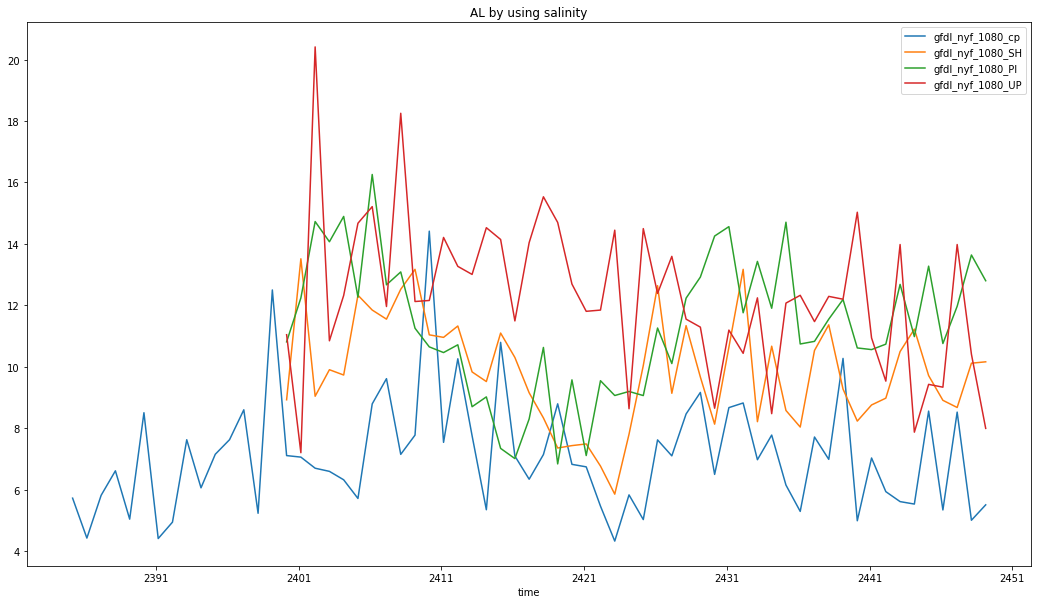

In [25]:
plt.figure(figsize=(18,10))
for expt in expts:
    al_mask2 = mask2(expt, 20, -42, -37, 35)
    al_tx_trans2 = calc_altransport2(expt, 20, -42, -37)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=expt)
plt.title('AL by using salinity')
plt.legend()

So it can be seen that a euqatorward shift can increase the AL and a strength of the wind intensity can directly increase the transport of AL.

# 4.2.1 The 2D transport distribution at x=20, above the salinity level = 35 and from y=-42 to y=-37 for 4 experiments.

In [26]:
@memory.cache
def mask2_2d(expt, x, yl, yr, saltlevel):
    
    salt=get_nc_variable(expt,'ocean.nc','salt', time_units='days since 1900-01-01')
    al_salt_2d = salt\
                .sel(yt_ocean=slice(yl, yr))\
                .sel(xt_ocean=x, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    al_mask2_2d = (al_salt_2d >= saltlevel)
    
    return al_mask2_2d

In [27]:
@memory.cache
def calc_altransport2_2d(expt, x, yl, yr):
    
    tx_trans=get_nc_variable(expt, 'ocean.nc','tx_trans', time_units='days since 1900-01-01')
    al_tx_trans2_2d = tx_trans\
                .sel(yt_ocean=slice(yl, yr))\
                .sel(xu_ocean=x)\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return al_tx_trans2_2d

In [28]:
@memory.cache
def tdsalt(expt):
    
    salt=get_nc_variable(expt,'ocean.nc','salt', time_units='days since 1900-01-01')
    al_salt_2d = salt\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return al_salt_2d

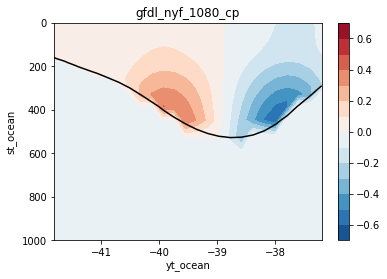

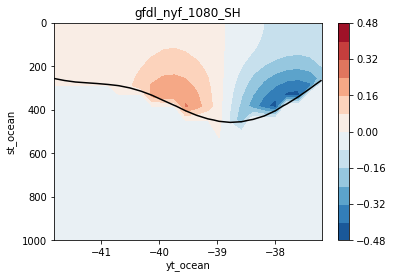

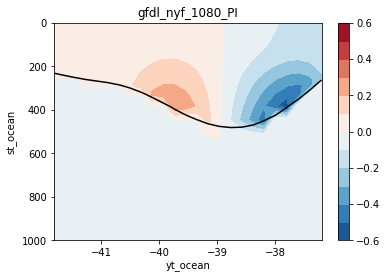

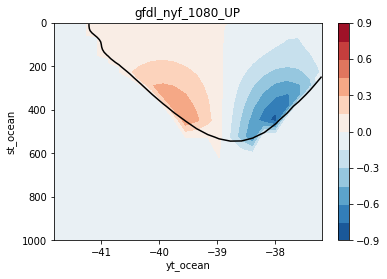

In [29]:
for expt in expts:
    
    al_mask2_2d = mask2_2d(expt, 20, -42, -37, 35)
    al_tx_trans2_2d = calc_altransport2_2d(expt, 20, -42, -37)
    al_salt_2d = tdsalt(expt)
    plt.figure()
    al_salt_2d.plot.contour(levels=[35], colors='k')
    (al_tx_trans2_2d * al_mask2_2d).plot.contourf(levels=15)   
    plt.ylim(1000, 0)
    plt.title(expt)

According to the figure, the change of AL mainly caused by the change of the Agulhas return current.

# 5.1 Agulhas Return Current calculated by using AC-AL

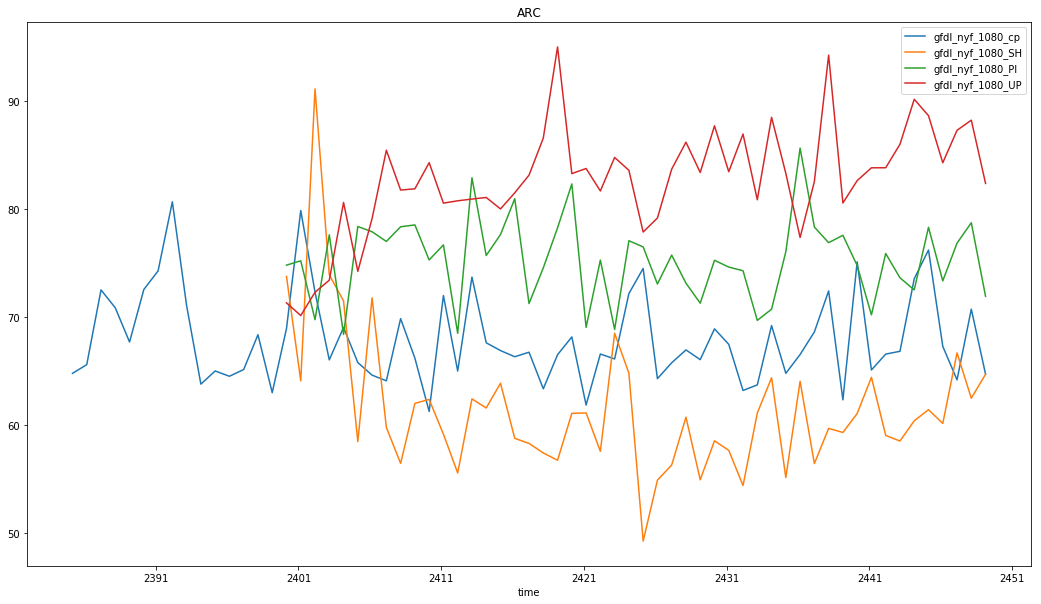

In [30]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport = calc_transport(expt) # transport function
    AC = -transport.sel(xu_ocean=32).min(dim='yt_ocean')
    al_mask = mask(expt)
    al_tx_trans = calc_altransport(expt)
    al_trans = -(al_tx_trans * al_mask).sum('yt_ocean').sum('st_ocean')
    ARetroC=AC-al_trans
    ARetroC.plot.line(label=expt)
plt.title('ARC')
plt.legend()


# 6.1 Transport at x=20, along the y direction for 4 experiments

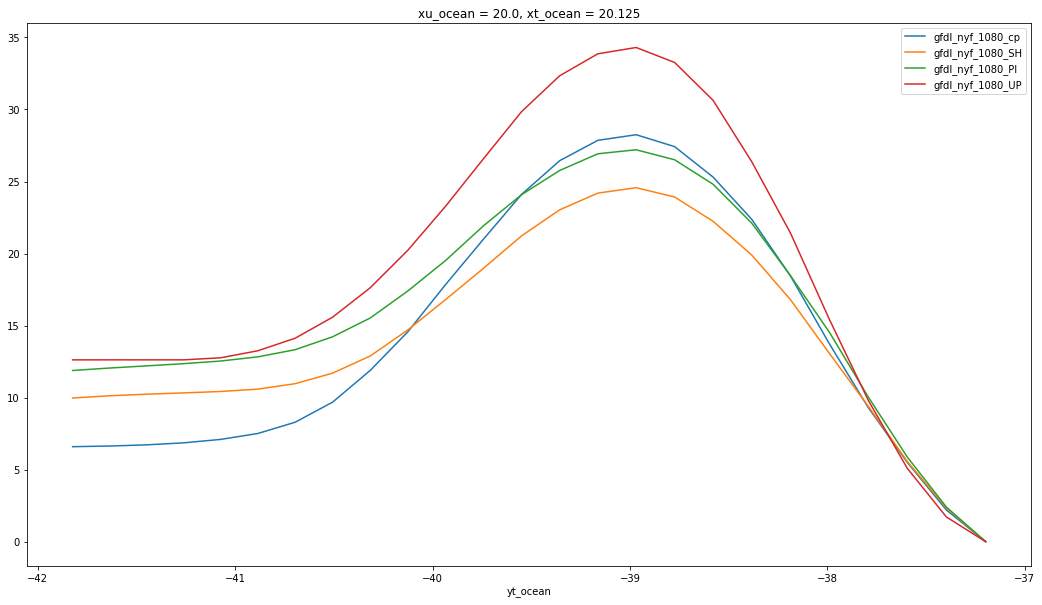

In [31]:
plt.figure(figsize=(18,10))
for expt in expts:
    temp = (calc_altransport2_2d(expt, 20, -42, -37) * mask2_2d(expt, 20, -42, -37, 35)).cumsum('yt_ocean')\
                                                                                                     .sum('st_ocean')
    temp1 = temp - temp[-1]
    temp1.plot(label=expt)
plt.legend(loc=0)   

# 6.2 Using the above series to calculate the Agulhas Return Current.

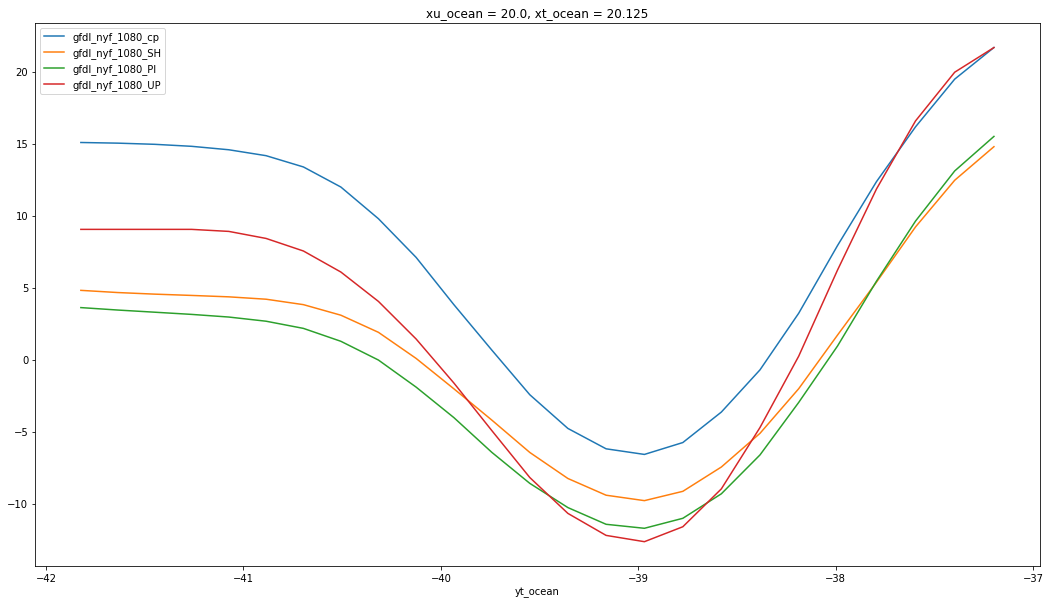

In [32]:
plt.figure(figsize=(18,10))
for expt in expts:
    temp = (calc_altransport2_2d(expt, 20, -42, -37) * mask2_2d(expt, 20, -42, -37, 35)).cumsum('yt_ocean')\
                                                                                                     .sum('st_ocean')
    temp1 = temp - temp[-1]
    ARC = temp.max(dim='yt_ocean')-temp1
    ARC.plot(label=expt)
plt.legend(loc=0)   

But we can see that, if we have a look at the mean of the time series that the other 3 effects can all result in a decrese in the transport of ARC.

# 7.1 Robust the result by altering the xt_ocean slice of reference experiment

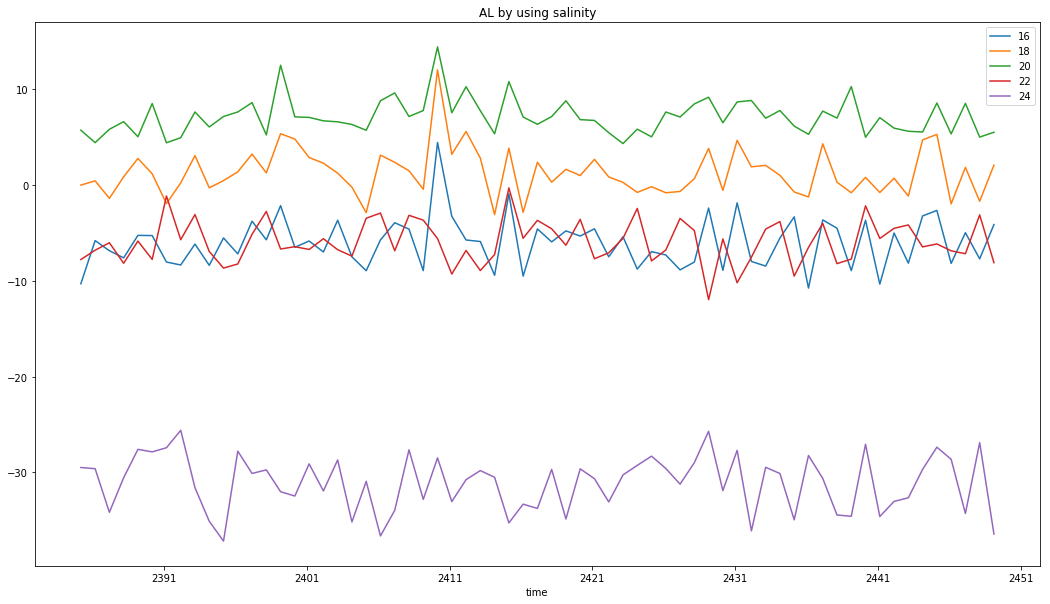

In [33]:
plt.figure(figsize=(18,10))
for x in [16, 18, 20, 22, 24]:
    al_mask2 = mask2(expts[0], x, -42, -37, 35)
    al_tx_trans2 = calc_altransport2(expts[0], x, -42, -37)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=x)
plt.title('AL by using salinity')
plt.legend()


## 7.1.1 temp plot for the x robust

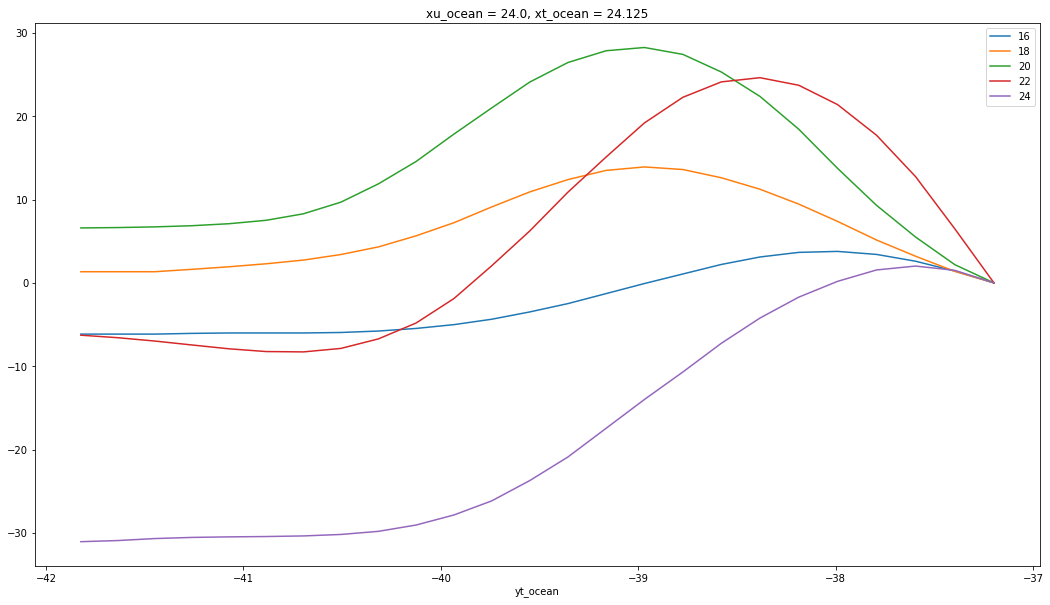

In [34]:
plt.figure(figsize=(18,10))
for x in [16, 18, 20, 22, 24]:
    temp = (calc_altransport2_2d(expts[0], x, -42, -37) * mask2_2d(expts[0], x, -42, -37, 35)).cumsum('yt_ocean')\
                                                                                                     .sum('st_ocean')
    temp1 = temp - temp[-1]
    temp1.plot(label=x)
plt.legend(loc=0) 

## 7.1.2 changing the step of x robust

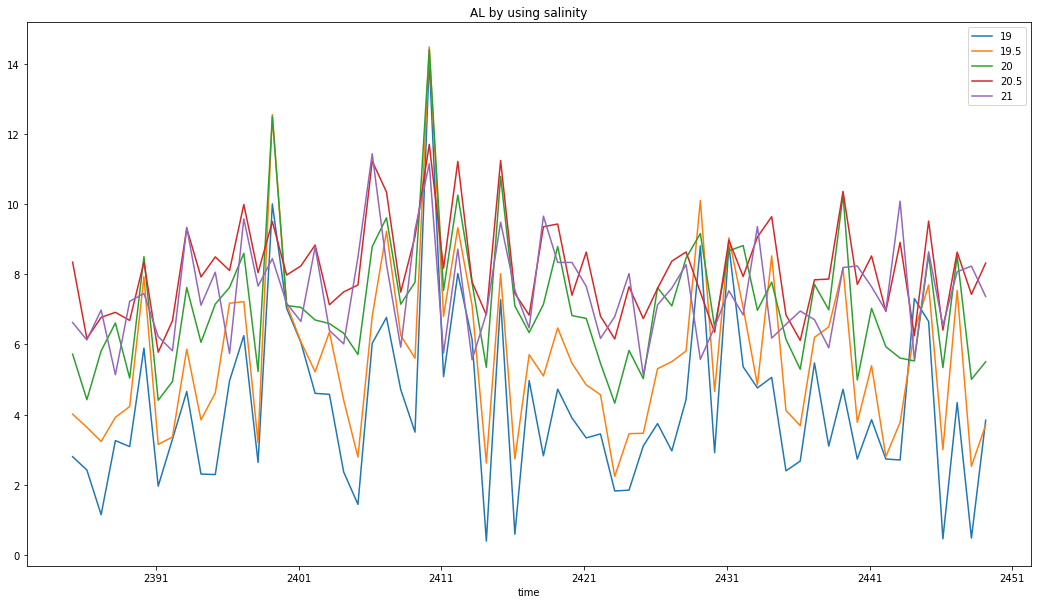

In [35]:
plt.figure(figsize=(18,10))
for x in [19, 19.5, 20, 20.5, 21]:
    al_mask2 = mask2(expts[0], x, -42, -37, 35)
    al_tx_trans2 = calc_altransport2(expts[0], x, -42, -37)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=x)
plt.title('AL by using salinity')
plt.legend()

## 7.1.3 The mean for of the transport series for the 5 selection value of x

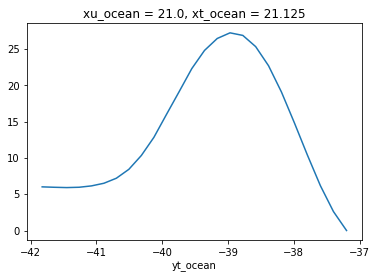

In [36]:
def tempt(x):
    temp = (calc_altransport2_2d(expts[0], x, -42, -37) * mask2_2d(expts[0], x, -42, -37, 35)).cumsum('yt_ocean')\
                                                                                                     .sum('st_ocean')
    tempt1 = temp - temp[-1]
    return tempt1

tempa=(tempt(19)+tempt(19.5)+tempt(20)+tempt(20.5)+tempt(21))/5
tempa.plot()

## 7.1.4 temp plot after changing the step

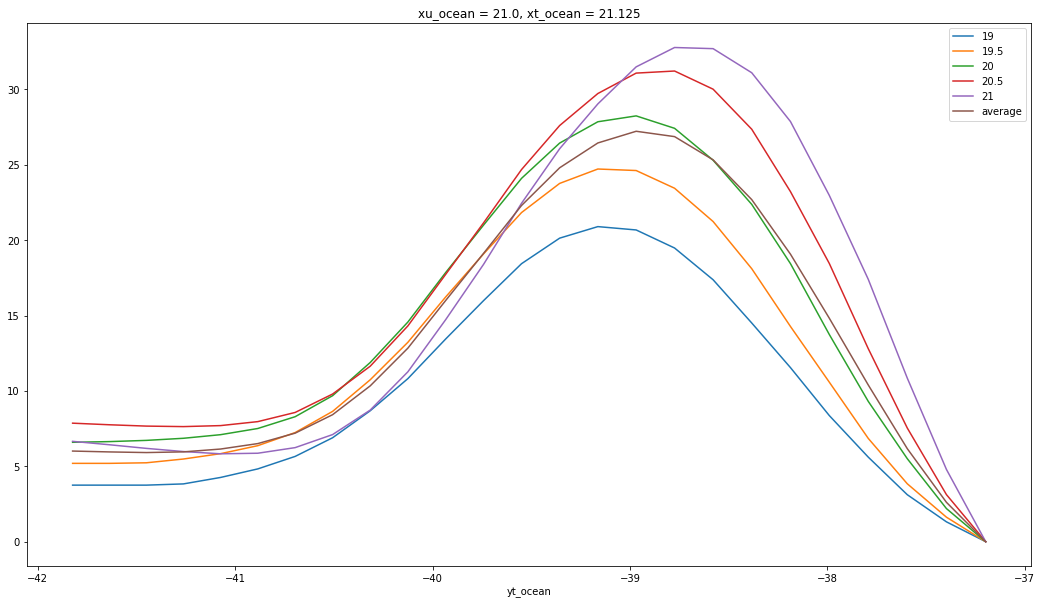

In [37]:
plt.figure(figsize=(18,10))
for x in [19, 19.5, 20, 20.5, 21]:
    temp = (calc_altransport2_2d(expts[0], x, -42, -37) * mask2_2d(expts[0], x, -42, -37, 35)).cumsum('yt_ocean')\
                                                                                                     .sum('st_ocean')
    temp1 = temp - temp[-1]
    temp1.plot(label=x)

 
tempa.plot(label='average')
plt.legend(loc=0)

After robusting the selection of the xt_ocean line, we cans see that the change of the AL is obvious with about 20%. The reason maybe caused by the effect of the eddies. By variating the position of the xt_ocean line, we can find out that the Agulhas current and ARC that taken into account change in the same way. However, the Agulhas leakage region is not in the range of the xt_ocean line, so the transport of the AL should not be affected, but the reality is that it does effect. And we put the reason on the effect of eddies. As we know, the form of the AL is in eddies. By choosing different x values, the edddies effect is different.

## 7.1.5 2D plot for the x robust after changing step

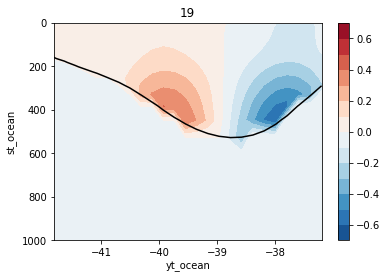

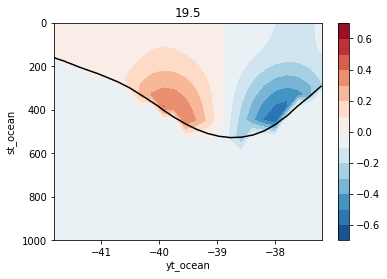

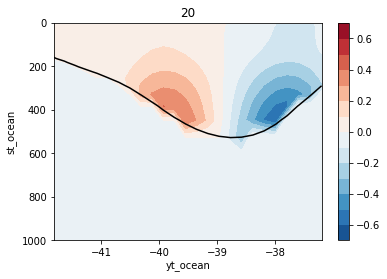

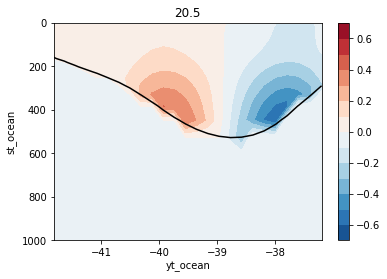

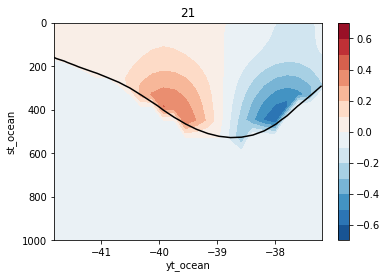

In [38]:
for x in [19, 19.5, 20, 20.5, 21]:
    
    al_mask2_2d = mask2_2d(expts[0], 20, -42, -37, 35)
    al_tx_trans2_2d = calc_altransport2_2d(expts[0], 20, -42, -37)
    al_salt_2d = tdsalt(expts[0])
    plt.figure()
    al_salt_2d.plot.contour(levels=[35], colors='k')
    (al_tx_trans2_2d * al_mask2_2d).plot.contourf(levels=15)   
    plt.ylim(1000, 0)
    plt.title(x)

I'd like to see if I do the average on 5 x values, the eddies effect should be canceled?

# 7.2 Robust the result by altering the salinity level of reference experiment

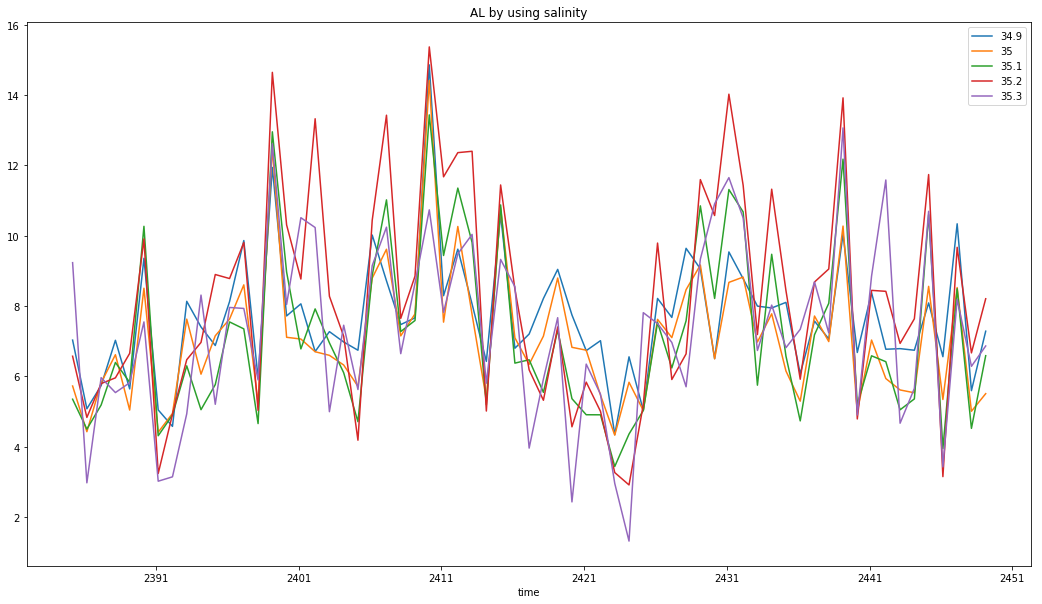

In [39]:
plt.figure(figsize=(18,10))
for saltlevel in [34.9, 35, 35.1, 35.2, 35.3]:
    al_mask2 = mask2(expts[0], 20, -42, -37, saltlevel)
    al_tx_trans2 = calc_altransport2(expts[0], 20, -42, -37)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=saltlevel)
plt.title('AL by using salinity')
plt.legend()

## 7.2.1 Robust the result by altering the yt_ocean range of reference experiment

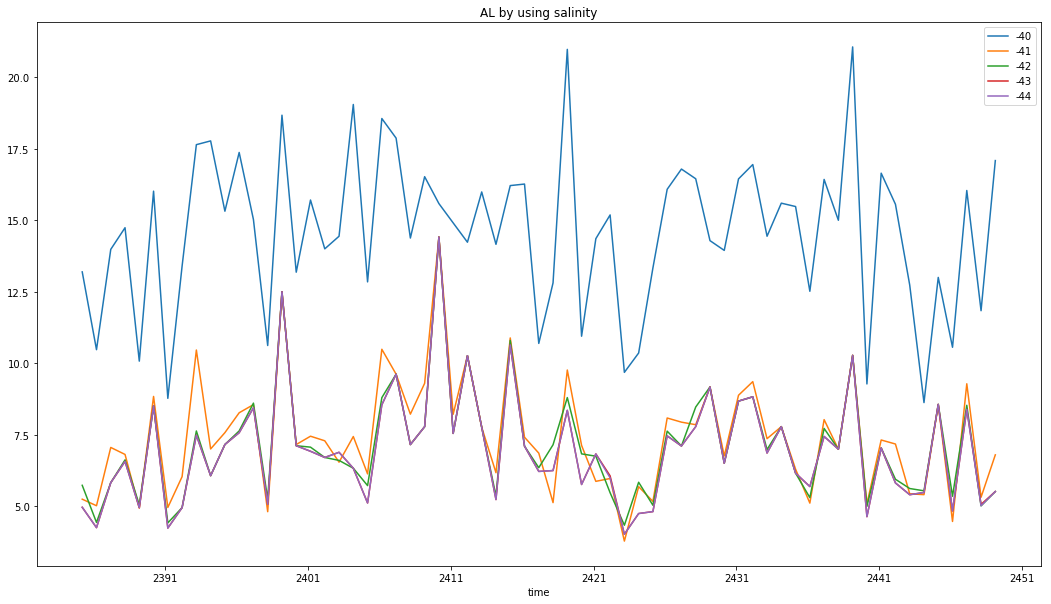

In [40]:
plt.figure(figsize=(18,10))
for yl in [-40, -41, -42, -43, -44]:
    al_mask2 = mask2(expts[0], 20, yl, -37, 35)
    al_tx_trans2 = calc_altransport2(expts[0], 20, yl, -37)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=yl)
plt.title('AL by using salinity')
plt.legend()

## 7.2.3

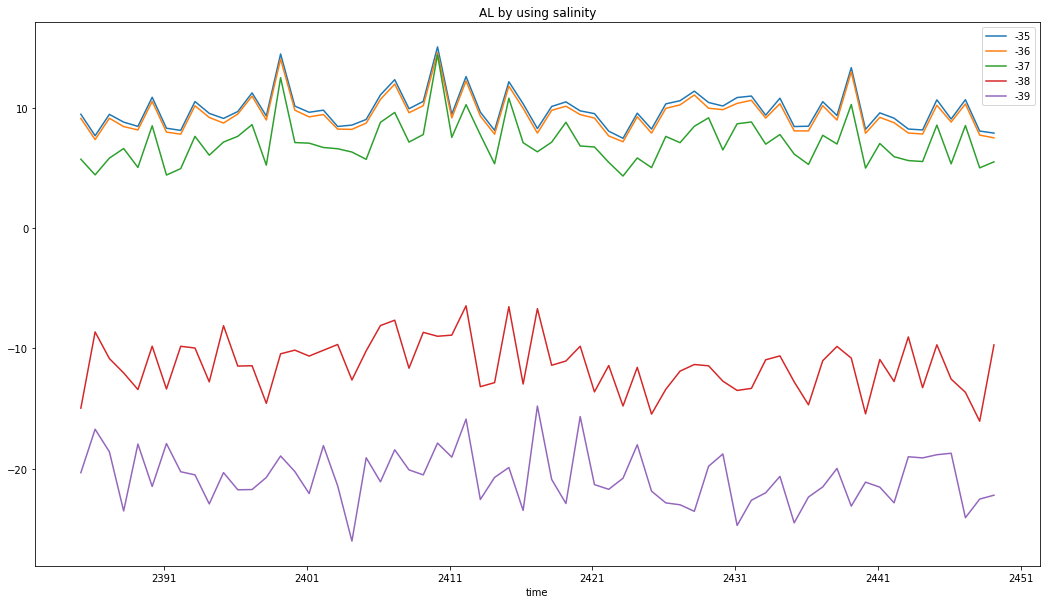

In [41]:
plt.figure(figsize=(18,10))
for yr in [-35, -36, -37, -38, -39]:
    al_mask2 = mask2(expts[0], 20, -42, yr, 35)
    al_tx_trans2 = calc_altransport2(expts[0], 20, -42, yr)
    al_trans2 = -(al_tx_trans2 * al_mask2).sum('yt_ocean').sum('st_ocean')
    al_trans2.plot.line(label=yr)
plt.title('AL by using salinity')
plt.legend()

# 8.1 Compare the year average result with 5 daily data result

In [43]:
@memory.cache
def calc_transport_5(expt):
    "Calculate the vertically integrate transport at time 0"
    
    tx_trans=get_nc_variable(expt, 'ocean__\d+_\d+.nc','tx_trans',n=1, time_units='days since 1900-01-01')

    tx_trans_inz=tx_trans.sel(yt_ocean=slice(None, -10))\
                     .sel(xu_ocean=slice(0, 60))\
                     .sum('st_ocean')  

    streamfunction = tx_trans_inz.cumsum('yt_ocean') # integrate in y direction

    streamfunction0 = streamfunction.sel(xu_ocean=20, yt_ocean=-10, method='nearest') # select somewhere
    # on the continent to be reference point 

    transport = - (streamfunction - streamfunction0) # To make the transport on the continent to be 0
    
    transport = transport.compute()
    
    return transport

In [44]:
plt.figure(figsize=(18,10))
for expt in expts:
    transport = calc_transport_5(expt) 
    ACC = transport.sel(xu_ocean=slice(20, 30)).max(dim='yt_ocean').max(dim='xu_ocean')
    ACC.plot(label=expt)
plt.title(ACC)
plt.legend()

________________________________________________________________________________
[Memory] Calling __main__--home-156-al1353-my_honours_project-__ipython-input__.calc_transport_5...
calc_transport_5('gfdl_nyf_1080_cp')


ValueError: No variable tx_trans found for gfdl_nyf_1080_cp in ocean__\d+_\d+.nc

In [ ]:
@memory.cache
def wind(expt):
    tau_x=get_nc_variable(expt,'ocean__\d+_\d+.nc','tau_x',n=10, time_units='days since 1900-01-01')
    wind_stress=tau_x.mean(dim='time').sel(yu_ocean=slice(-60,-30)).isel(xu_ocean=slice(1000,1400))\
                                                                                  .mean(dim='xu_ocean')
    return wind_stress

# The transport calculated by using 5-days experiment

@memory.cache
def calc_AL_tx_trans_5d(expt):
    
    u = get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', time_units='days since 1900-01-01', n=10)
    dy = get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'yu_ocean', time_units='days since 1900-01-01', n=10)
    dz= get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'st_ocean', time_units='days since 1900-01-01', n=10)
    tx_trans_5d = u*dy*dz
    AL_tx_trans_5d = tx_trans_5d\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xu_ocean=20)\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return AL_tx_trans_5d

u = get_nc_variable(expts[0], 'ocean__\d+_\d+.nc', 'u', time_units='days since 1900-01-01', n=1)

tx_trans_rho = get_nc_variable(expts[0], 'ocean__\d+_\d+.nc', 'tx_trans_rho', time_units='days since 1900-01-01', n=1)
tx_trans_rho

# Defining the mask for the 5-days experiment

@memory.cache
def mask_5d(expt):
    
    rho_5d=get_nc_variable(expt,'ocean__\d+_\d+.nc','pot_rho_0', time_units='days since 1900-01-01',n=10)
    AL_rho_5d = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    AL_mask_5d = (AL_rho_5d <= 1026.5)
    
    return AL_mask_5d

plt.figure(figsize=(18,10))
temp_5d = (calc_AL_tx_trans_5d(expt[0]) * mask_5d(expt[0])).cumsum('yt_ocean').sum('st_ocean')
temp1_5d = temp_5d - temp_5d[-1]
temp1_5d.plot()


expt=expts[0]
print(expt)
u = get_nc_variable(expt, 'ocean__\d+_\d+.nc', 'u', time_units='days since 1700-01-01', n=10)

@memory.cache
def tdrho(expt):
    
    rho=get_nc_variable(expt,'ocean.nc','pot_rho_0', time_units='days since 1900-01-01')
    al_rho_2d = rho\
                .sel(yt_ocean=slice(-42, -37))\
                .sel(xt_ocean=20, method='nearest')\
                .isel(time=slice(None,100)).mean(dim='time')\
                .compute()
    
    return al_rho_2d